<a href="https://colab.research.google.com/github/sgulyano/mat202/blob/main/lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MAT-202 Lab 5: Image Filtering in Frequency Domain

CMKL University

By Sarun Gulyanon


### Goal

Introduce students to the fundamental concepts and techniques of performing convolution in the frequency domain and demonstrate that it is equivalent to convolution in the spatial domain.

### Outline

In this lab, students will first review the Fourier Transform, then explore and implement image convolution in the frequency domain.

----

## 1. Recap of the Fourier transform

As we have covered in our lecture notes, here is the expression for the 2D Fourier Transform (FT):

$$F(u,v) = \int{ \int{ f(x,y) e^{-j 2 \pi (x u + y v)} dx dy}}$$

And here is the expression for the inverse Fourier Transform:

$$ f(x,y) = \int{ \int{ \hat{f}(u,v) e^{i 2 \pi (x u + y v)} du dv}}$$

For digital images, we use the 2D Discrete Fourier Transform (DFT):

$$ F(u,v) = \sum_{x=0}^{M-1} \sum_{y=0}^{N-1}
f(x,y) \, e^{-j 2\pi \left( \frac{ux}{M} + \frac{vy}{N} \right)}$$

And its inverse Discrete Fourier Transform (IDFT):

$$f(x,y) = \frac{1}{MN} \sum_{u=0}^{M-1} \sum_{v=0}^{N-1} F(u,v) \, e^{j 2\pi \left( \frac{ux}{M} + \frac{vy}{N} \right)}$$



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate, zoom

In [2]:
# Helper function to compute the magnitude and phase
def fourier_spectrum(img):
    F = np.fft.fftshift(np.fft.fft2(img))
    magnitude = np.abs(F)
    phase = np.angle(F)
    return magnitude, phase

In [3]:
# Create a synthetic 2D wave pattern
size = 64
u0, v0 = 0.05, 0.0

x = np.arange(size)
y = np.arange(size)
X, Y = np.meshgrid(x, y)
img = np.sin(2 * np.pi * (u0 * X + v0 * Y))

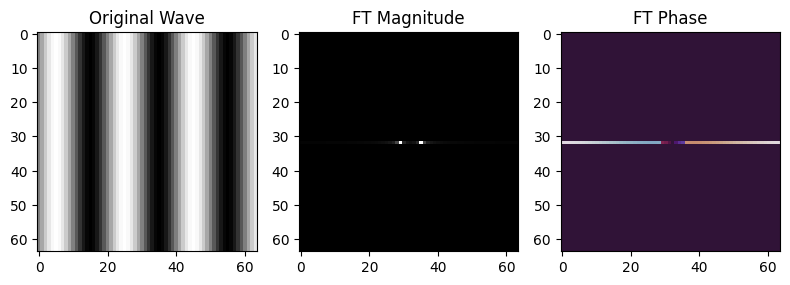

In [4]:
mag_ori, phase_ori = fourier_spectrum(img)

plt.figure(figsize=(8, 3))
plt.subplot(1, 3, 1); plt.imshow(img, cmap='gray'); plt.title('Original Wave')
plt.subplot(1, 3, 2); plt.imshow(mag_ori, cmap='gray'); plt.title('FT Magnitude')
plt.subplot(1, 3, 3); plt.imshow(phase_ori, cmap='twilight'); plt.title('FT Phase')
plt.tight_layout()
plt.show()

### Shift Property

A spatial shift in the image corresponds to a phase shift in the Fourier domain.
It changes only the phase, not the magnitude of the spectrum.

$$ f(x - x_0, y - y_0) \;\Longleftrightarrow\; e^{-j 2\pi (u x_0 + v y_0)} F(u,v) $$

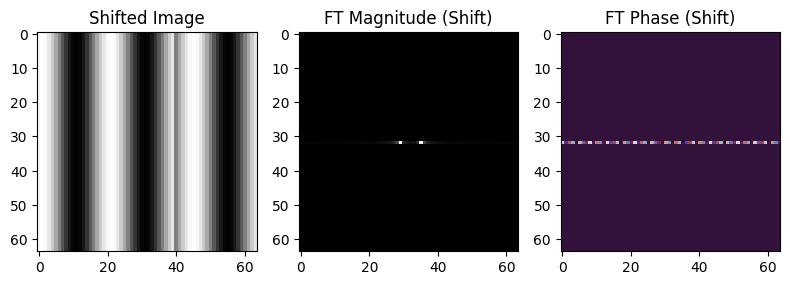

In [5]:
shifted_img = np.roll(img, 40, axis=1)

mag_shifted, phase_shifted = fourier_spectrum(shifted_img)

plt.figure(figsize=(8, 3))
plt.subplot(1, 3, 1); plt.imshow(shifted_img, cmap='gray'); plt.title('Shifted Image')
plt.subplot(1, 3, 2); plt.imshow(mag_shifted, cmap='gray'); plt.title('FT Magnitude (Shift)')
plt.subplot(1, 3, 3); plt.imshow(phase_shifted, cmap='twilight'); plt.title('FT Phase (Shift)')
plt.tight_layout()
plt.show()

### Rotation Property

Rotating an image in the spatial domain causes the frequency spectrum to rotate by the same angle.

$$ f(x \cos\theta + y \sin\theta, -x \sin\theta + y \cos\theta)
\;\Longleftrightarrow\; F(u \cos\theta + v \sin\theta, -u \sin\theta + v \cos\theta) $$

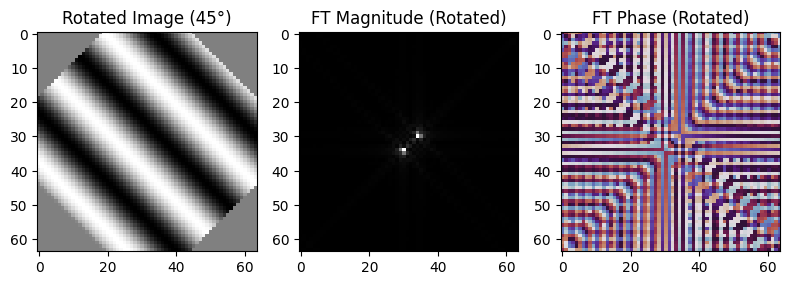

In [6]:
rotated_img = rotate(img, 45, reshape=False)
mag_rotated, phase_rotated = fourier_spectrum(rotated_img)

plt.figure(figsize=(8, 3))
plt.subplot(1, 3, 1); plt.imshow(rotated_img, cmap='gray'); plt.title('Rotated Image (45°)')
plt.subplot(1, 3, 2); plt.imshow(mag_rotated, cmap='gray'); plt.title('FT Magnitude (Rotated)')
plt.subplot(1, 3, 3); plt.imshow(phase_rotated, cmap='twilight'); plt.title('FT Phase (Rotated)')
plt.tight_layout()
plt.show()

### Superposition Property

The Fourier Transform is linear so the transform of a sum equals the sum of the transforms.

$$ a\,f_1(x, y) + b\,f_2(x, y) \;\Longleftrightarrow\; a\,F_1(u, v) + b\,F_2(u, v) $$

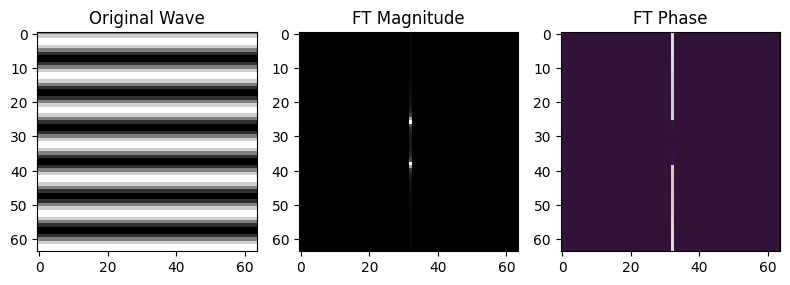

In [7]:
# Create another synthetic 2D wave pattern
u2, v2 = 0.0, 0.10
img2 = np.sin(2 * np.pi * (u2 * X + v2 * Y))

mag_ori2, phase_ori2 = fourier_spectrum(img2)

plt.figure(figsize=(8, 3))
plt.subplot(1, 3, 1); plt.imshow(img2, cmap='gray'); plt.title('Original Wave')
plt.subplot(1, 3, 2); plt.imshow(mag_ori2, cmap='gray'); plt.title('FT Magnitude')
plt.subplot(1, 3, 3); plt.imshow(phase_ori2, cmap='twilight'); plt.title('FT Phase')
plt.tight_layout()
plt.show()


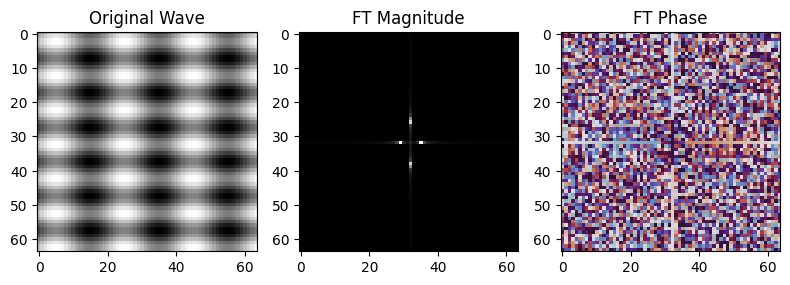

In [8]:
img_superposed = img + img2
mag_sup, phase_sup = fourier_spectrum(img_superposed)

plt.figure(figsize=(8, 3))
plt.subplot(1, 3, 1); plt.imshow(img_superposed, cmap='gray'); plt.title('Original Wave')
plt.subplot(1, 3, 2); plt.imshow(mag_sup, cmap='gray'); plt.title('FT Magnitude')
plt.subplot(1, 3, 3); plt.imshow(phase_sup, cmap='twilight'); plt.title('FT Phase')
plt.tight_layout()
plt.show()

## 2. Image Convolution in Frequency Domain

Convolution in the spatial domain can be efficiently performed in the frequency domain using the Fourier Transform.

According to the Convolution Theorem:

$$ f(x, y) * h(x, y) \;\Longleftrightarrow\; F(u, v) \cdot H(u, v) $$

This means we can compute image filtering by:
1. Take the Fourier Transform of both the image and the filter kernel
2. Multiply them element-wise in the frequency domain
3. Apply the inverse Fourier Transform to obtain the filtered image

This approach is particularly useful for large filters, where direct spatial convolution would be computationally expensive.

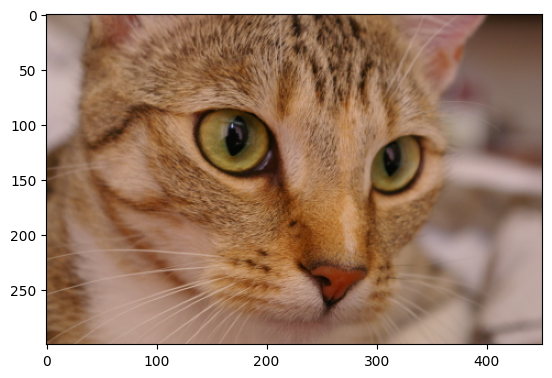

In [9]:
import cv2
import numpy as np
from skimage import data
import matplotlib.pyplot as plt
%matplotlib inline


#@title Select Image {run: 'auto'}
image_name = 'cat' #@param ['astronaut', 'camera', 'cat', 'coffee', 'checkerboard', 'page']

img = getattr(data, image_name)()
img = img/255.

if img.ndim < 3:
    plt.imshow(img, cmap='gray')
else:
    plt.imshow(img)
plt.show()

In [10]:
def gaussian_kernel(size, sigma=1):
    """
    Generate 2D Gaussian kernel
    Input:  size = size of the Gaussian kernel
            sigma = sigma of the Gaussian function
    Output: 2D array of the Gaussian kernel
    """
    n = size//2
    xx, yy = np.meshgrid(range(-n,n+1), range(-n,n+1))
    kernel = np.exp(- (xx**2 + yy**2) / (2*sigma**2))
    kernel = kernel / kernel.sum()
    return kernel

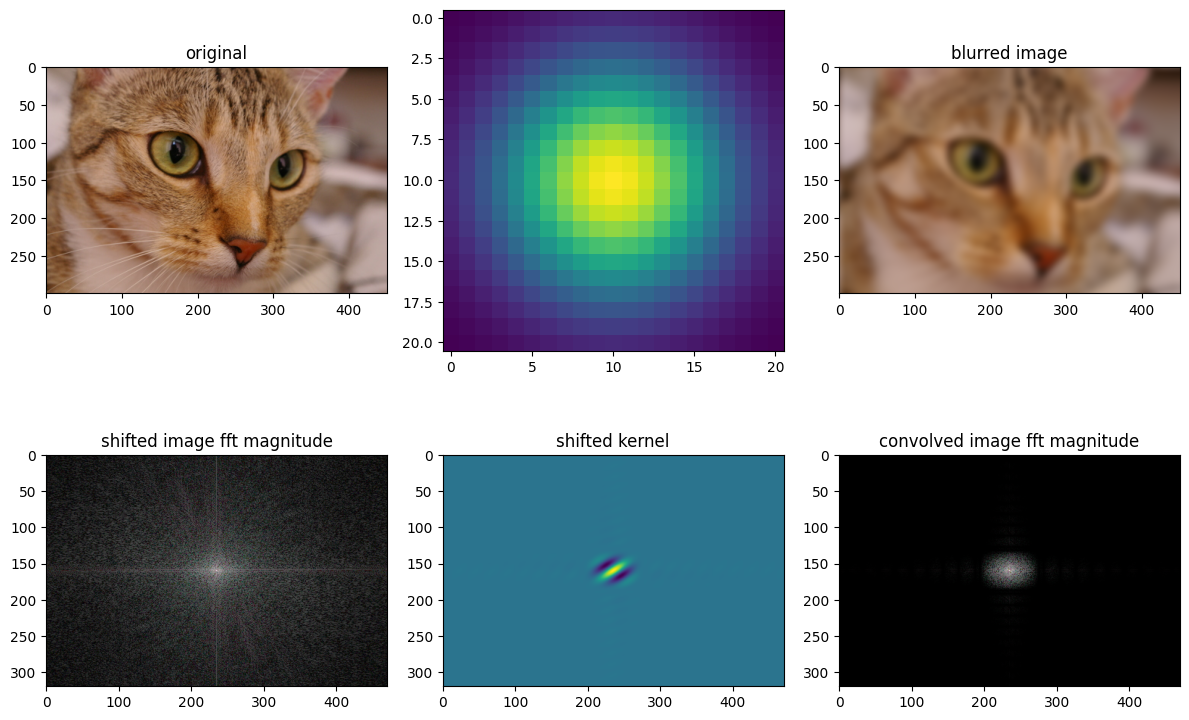

In [11]:
kernel_size=21
sigma=5

kernel = gaussian_kernel(kernel_size, sigma)

kernel_row, kernel_col = kernel.shape

# pad image for convolution at edges
pad_height = kernel.shape[0] // 2
pad_width = kernel.shape[1] // 2

padded_image = np.pad(img, ((pad_height, pad_height), (pad_width, pad_width), (0, 0)), 'edge')

# Take the Fourier Transform of both the image and the filter kernel
kernel_fft = np.fft.fft2(kernel, s=padded_image.shape[:2], axes=(0, 1))
image_fft = np.fft.fft2(padded_image, axes=(0, 1))

# Multiply them element-wise in the frequency domain
convolved_fft = kernel_fft[:, :, np.newaxis] * image_fft

# Apply the inverse Fourier Transform to obtain the filtered image
convolved_image = np.fft.ifft2(convolved_fft, axes=(0, 1)).real

# Crop back to original size
convolved_image = convolved_image[pad_height:-pad_height, pad_width:-pad_width, :]
convolved_image = np.clip(convolved_image, 0, 1)

# Shift FTs for visualization
image_fft_shift = np.log( abs(np.fft.fftshift(image_fft).real) + 1 )
kernel_fft_shift = np.fft.fftshift(kernel_fft)
convolved_fft_shift = np.log( abs(np.fft.fftshift(convolved_fft).real) + 1 )

plt.figure(figsize=(12, 8))
plt.subplot(2,3,1)
plt.imshow(img)
plt.title('original')
plt.subplot(2,3,2)
plt.imshow(kernel)
plt.subplot(2,3,3)
plt.imshow(convolved_image)
plt.title('blurred image')

plt.subplot(2,3,4)
plt.imshow(image_fft_shift / image_fft_shift.max())
plt.title('shifted image fft magnitude')
plt.subplot(2,3,5)
plt.imshow(kernel_fft_shift.real)
plt.title('shifted kernel')
plt.subplot(2,3,6)
plt.imshow(convolved_fft_shift / convolved_fft_shift.max())
plt.title('convolved image fft magnitude')
plt.tight_layout()
plt.show()

## Exercise:

What Happens When You Forget to Pad the Image?

Try performing the frequency-domain convolution without padding the image.
Observe the result.

### Solution

You should notice wrap-around artifacts near the image boundaries.

----